In [1]:
# Read the CSV file as a sparse matrix
# File path: /mnt/volume1/qyc/data/Inter-dataset/PbmcBench/CEL-Seq/CL_pbmc1.csv
# Format: genes as columns, cells as rows
import pandas as pd
import scipy.sparse as sp

# Read the CSV file
df = pd.read_csv('/mnt/volume1/qyc/data/Inter-dataset/PbmcBench/CEL-Seq/CL_pbmc1.csv', index_col=0)

# Convert to sparse matrix
sparse_matrix = sp.csr_matrix(df.values)

In [6]:
true_label = pd.read_csv("/mnt/volume1/qyc/auto-annot/result_across/singleCellNet/singleCellNet_True_Labels.csv")
pred_label = pd.read_csv("/mnt/volume1/qyc/auto-annot/result_across/singleCellNet/singleCellNet_Pred_Labels.csv")

In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

/home/srtp/anaconda3/envs/bidcell/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/srtp/anaconda3/envs/bidcell/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/srtp/anaconda3/envs/bidcell/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/srtp/anaconda3/envs/bidcell/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/srtp/anaconda3/envs/bidcell/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing 

In [4]:
# 设置scanpy参数
sc.settings.set_figure_params(dpi=100, frameon=False)
sc.settings.verbosity = 3

# 创建AnnData对象
adata = sc.AnnData(sparse_matrix)

In [7]:
# 添加标签信息
adata.obs['true_label'] = true_label.values.flatten()
adata.obs['pred_label'] = pred_label.values.flatten()

In [8]:
# 预处理
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

filtered out 1825 cells that have less than 200 genes expressed
filtered out 594 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/srtp/anaconda3/envs/bidcell/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [9]:
# 降维
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)


computing PCA
    with n_comps=50
    finished (0:00:22)
computing neighbors
    using 'X_pca' with n_pcs = 40


2025-05-24 23:04:44.612103: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-24 23:04:49.056472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:37)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


In [31]:
# 聚类
sc.tl.leiden(adata, resolution=0.8)
adata.obs['cluster'] = adata.obs['leiden']

running Leiden clustering
    finished: found 27 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


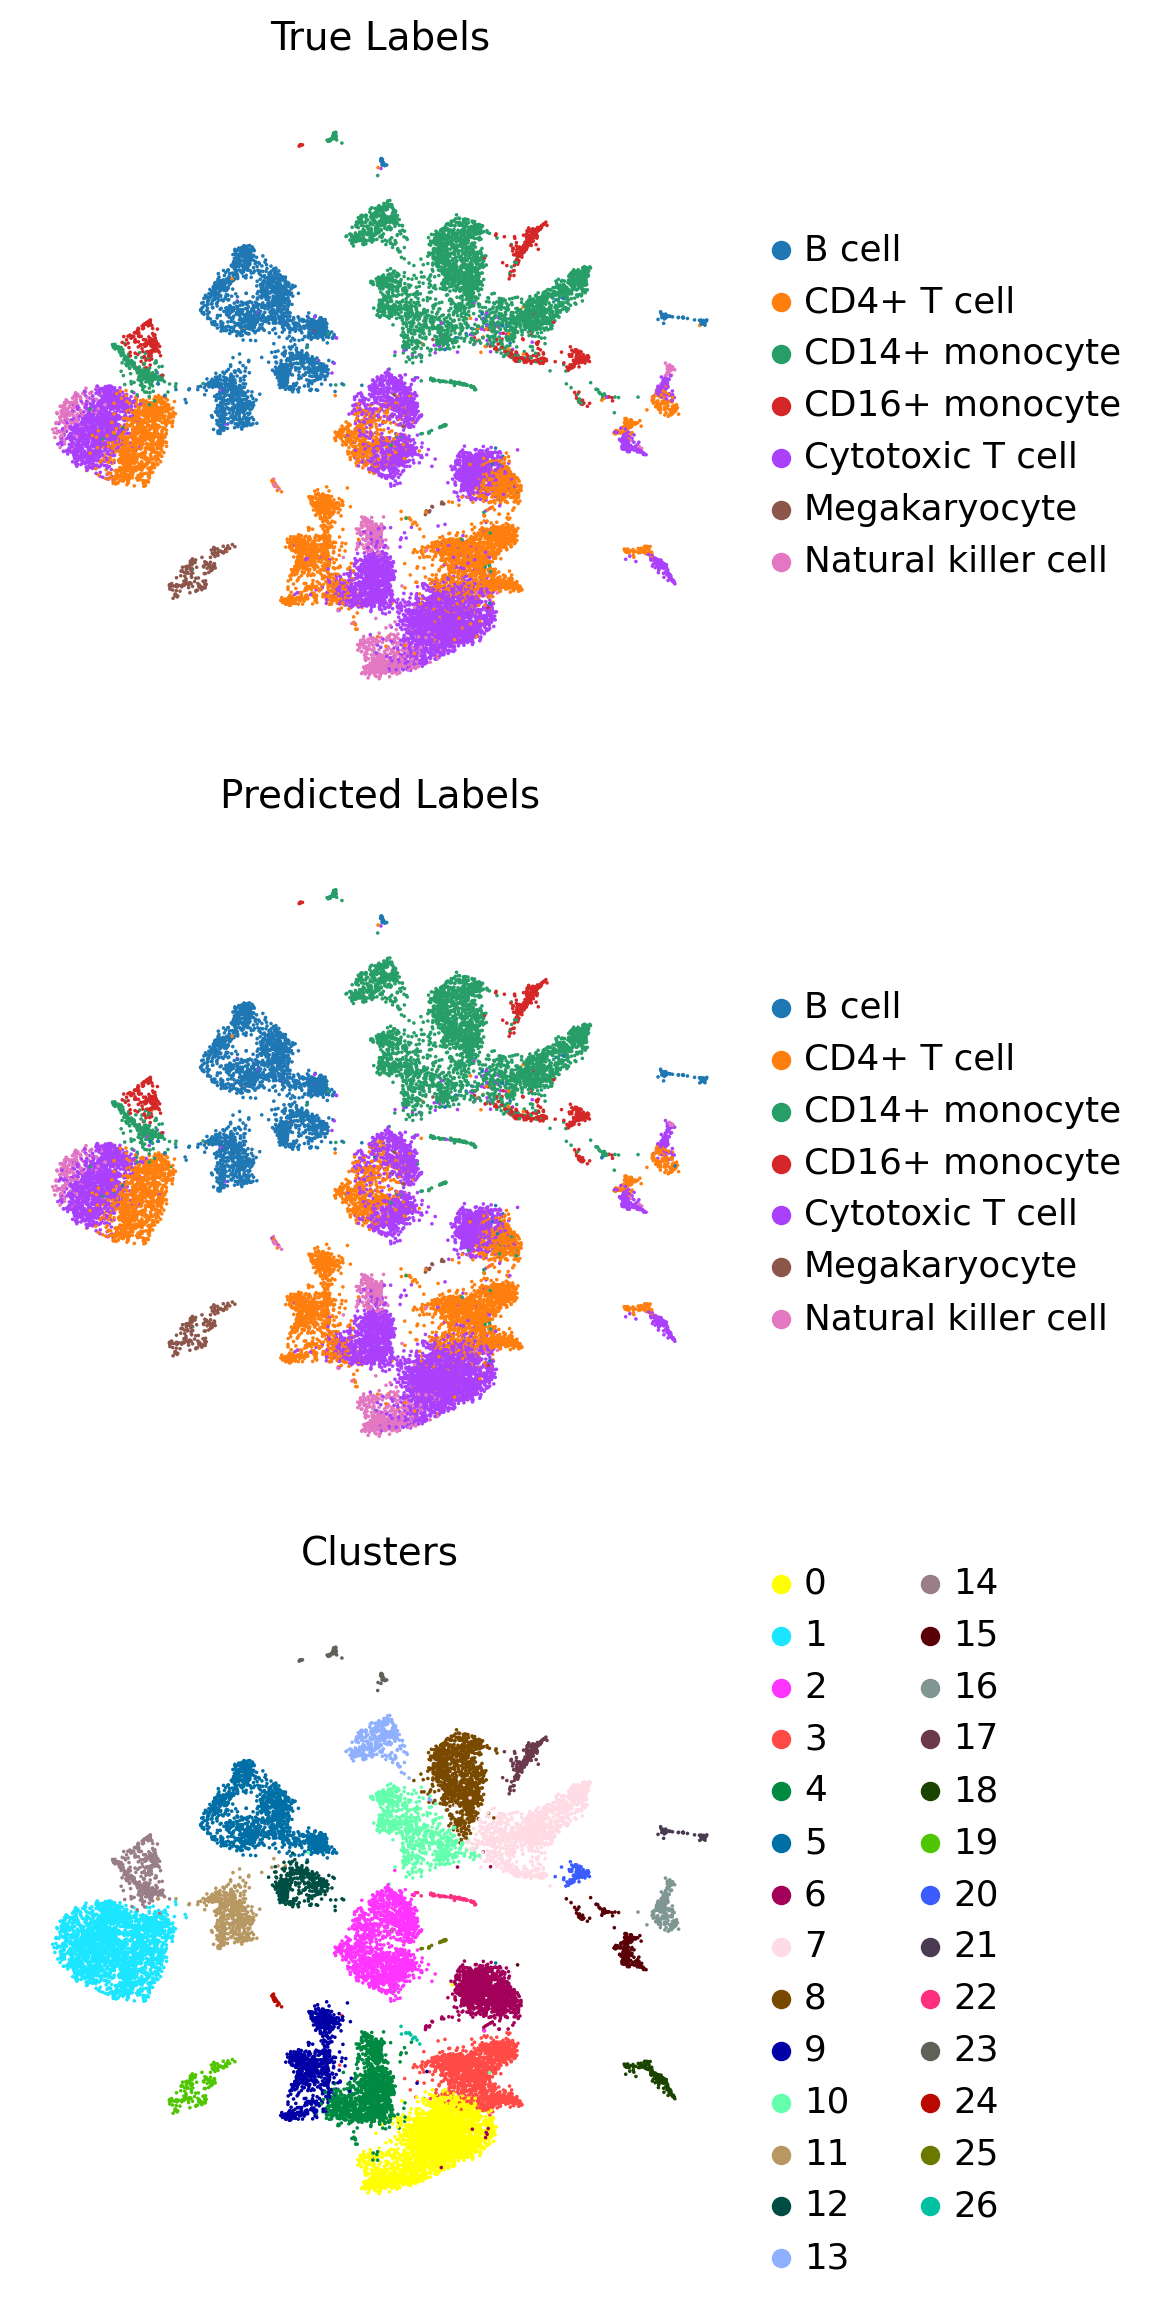

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

In [32]:
# 创建图形
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 12))

# 绘制真实标签的UMAP
sc.pl.umap(adata, color='true_label', ax=ax1, show=False, title='True Labels')
ax1.set_title('True Labels', pad=20)

# 绘制预测标签的UMAP
sc.pl.umap(adata, color='pred_label', ax=ax2, show=False, title='Predicted Labels')
ax2.set_title('Predicted Labels', pad=20)

# 绘制聚类结果的UMAP
sc.pl.umap(adata, color='cluster', ax=ax3, show=False, title='Clusters')
ax3.set_title('Clusters', pad=20)

# 调整布局
plt.tight_layout()

# 分别保存三张图
# 真实标签
plt.figure(figsize=(6, 6))
sc.pl.umap(adata, color='true_label', show=False, title='True Labels')
plt.savefig('umap_true_labels.pdf', bbox_inches='tight')
plt.close()

# 预测标签
plt.figure(figsize=(6, 6))
sc.pl.umap(adata, color='pred_label', show=False, title='Predicted Labels')
plt.savefig('umap_pred_labels.pdf', bbox_inches='tight')
plt.close()

# 聚类结果
plt.figure(figsize=(6, 6))
sc.pl.umap(adata, color='cluster', show=False, title='Clusters')
plt.savefig('umap_clusters.pdf', bbox_inches='tight')
plt.close()